# Orientações

## Objetivo

Desenvolver um modelo de classificação que seja capaz de prever se o cliente irá cancelar o serviço ou não (Churn).

- Comparar mais de um modelo com gráficos
- Documentar etapas justificando as decisões

## Sobre os dados

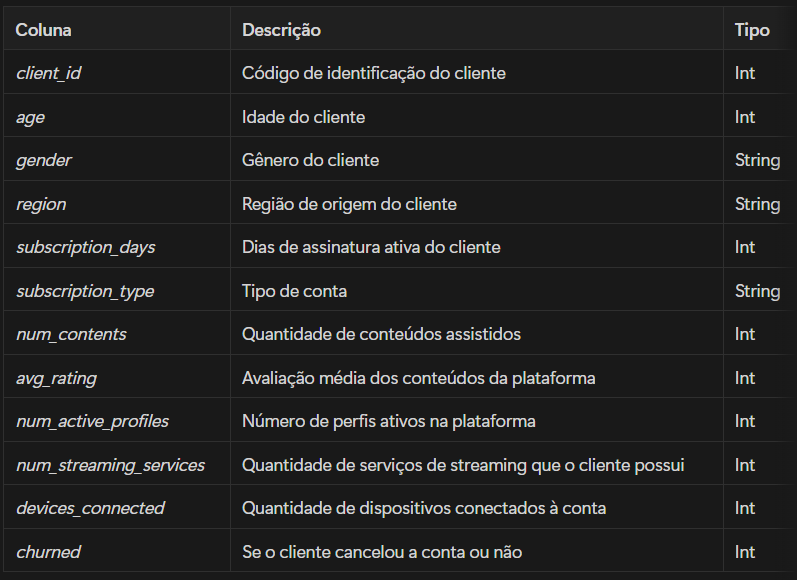

# Preparação

Vamos instalar algumas dependências que nos ajudarão na exploração dos dados.

In [1]:
%pip install summarytools -q

Note: you may need to restart the kernel to use updated packages.


Agora, seguiremos para a importação das dependências.

In [2]:
import pandas as pd
import plotly.express as px
from summarytools import dfSummary

# Etapa 01) Análise exploratória dos dados (Data Understanding)



Critérios de Avaliação:

 Para esta etapa os alunos precisam trabalhar a base de dados para entender com estão as distribuição dos dados, para isso eles precisam fazer as etapas: Describe, Info, isna().sum()


## Carregar a Base de Dados

In [3]:
df = pd.read_csv("streaming_data.csv", encoding='latin')

## Descrição estatística dos dados

In [4]:
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


Temos um dataset com 77884 itens.

O Dataset está desbalanceado para a variável target "Churned", possuindo uma maioria de casos negativos.

In [5]:
fig = px.bar(df.Churned.value_counts())
fig.show()

Vamos utilizar a Summary Tools para obter um describe mais elaborado.

In [6]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[float64],Mean (sd) : 43.5 (15.0)min < med < max:18.0 < 43.0 < 69.0IQR (CV) : 27.0 (2.9),52 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACe0lEQVR4nO3aPW8aQRRG4TtgrME4u+Ij0NGktJQCicZNupT+sWnTpcBSahdpUtEgJIRBbIxYFlJFqYzZWa3hRedp4XJH6BTA4Pb7vQHnrnLqAwDHuDr1AXA5nHN1M7sOHN/s9/uX1x58M9Qyl+NyOOfq7Xb7IYqiZsj8crmcO+e+vdbLwVDLXo6Lch1FUfP+/v4ljuN1nsHFYuFHo1FzNptdm1n+UMtejssTx/G62+3+CRitH3rwqM+oZS0HjsW3fkggVEggVEggVEggVEggVEgo9Qo1y7KamUXOudCX4GYLZlZiqEmS1NI0/dzv96vVajXXZcE/z8/PK+fcdzMLmS8UecGr44qZ7U4we8rd0W63qwXOvqm0UDebzZX3/mYwGKx7vd487/xkMvnw+Pj4pd/vd0JCLxi5b7VaX+M4buQdzLKsliTJp9vb29+VSiV9r9lT707T1GdZdrder3+YWcjl0EGl/3uq0WgE3WrN5/N6aOhFI0/T1JvZ3XA4/NnpdJZ5ZsfjcfPp6enjYDD4lffcRWbPZPfNdrut5p09xtn/zS8k9CKRm/1/0733achus/Bzh86ey+6ynH2oRZzrm478+HkKEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEq6OedJisfB5X3i1WnkzsyRJ/HQ6vXnPedXdqucuOn9MX38Bh/RXCYp1T58AAAAASUVORK5CYII="">","11,277(14.5%)"
2,Gender[object],1. Male2. Female3. nan,"31,796 (40.8%)31,572 (40.5%)14,516 (18.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABfUlEQVR4nO3bwWnjYBSF0adBhMlGwhhcjIuYYqcIdWOM/0USslEW6eG+xX9OBc/wYSOju5znWZDwp/sA5rFU1XtVvXUf0uT7PM/P7iNmsV6v13/btl26D+kwxnguy/JfcBnrtm2X+/3+ue/7V/cxSa/X6+9xHJfH4/FWVWILWKuq9n3/ut1uH93HNHjvPmAmHhCIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEbNW/b7b1X1I2oyfuds6xngex3GpCd/tGmM8q+q7+45Z2CB4JTxmMeUjxTebb7YY6yrrqhjrKuuqGOsqYvypS4zYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0Y6ypirKusq2JsELwSHmNdRYwHBGK6fkb9fE2oZcpnQjen+JTPhG5eXVO+6f5mwQMCQWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLiUz4Tunm1TPlM6OZkg0CMKR8xP0q8o0q79GxzAAAAAElFTkSuQmCC"">","14,516(18.6%)"
3,Time_on_platform[float64],Mean (sd) : 4385.8 (2526.6)min < med < max:0.0 < 4384.0 < 8759.0IQR (CV) : 4377.0 (1.7),"8,721 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACj0lEQVR4nO3YvW/aUBSG8XOBkMtHbfFRsrF0jNQBiYWlW8f+sV27FSlInRm6dMoSRUKOEW4QhtIhqsREsE1wX+n5rcnJ9T16sFDcfr834H9XKfsBgFPUyn4AnJdzrmFm9Zzjm/1+/3zO5zmXNw214NLMCiyuzLPL4pxr9Hq9L0EQdPLML5fLyDn3taSdH933m4VadGlmZk9PTyvn3DczW2cc9d1u93MYhq0SzjZ7+Ur1J+fRRWaDdrs9mEwmyzAMMz13HMd+Op0OFotF3zm3zHF2oZ2/9iF5NdQCn5LcSzMze3h4eDebzT4Nh8N+tVrNNJ+mqTez2/F4/KPf72deepGzd7vdVZIkH9rt9q9KpZJeatbs5d673e72+vr6+2Aw+J1lNkmSqzRNPw6Hw2rWO/8723LuPI5jf3d311ksFnUzyx5qkbdikaWZmUVR1PDeN0ej0frm5ibKMnt/f9+Zz+dN731a0tnvR6PRz0vOHsw3t9ttNevsZrOp5b3z4dl5d25mjWM/fO2NWg+CoDOZTJ6zvhWLLO1Qq9VaZ714FEVHL32Jsy89ezhfRJlnH3PSd9QwDEuLBTDj/6gQQaiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQUDvll+I49ln/8Gq18mZmSZL4x8fH5iXnVc9Wfe6i86f09RfFHkfgT/6ALQAAAABJRU5ErkJggg=="">","21,420(27.5%)"
4,Devices_connected[float64],1. nan2. 1.03. 4.04. 2.05. 3.06. 5.0,"25,188 (32.3%)10,587 (13.6%)10,587 (13.6%)10,583 (13.6%)10,476 (13.5%)10,463 (13.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQ0lEQVR4nO3bMW4aUQBF0U+ErLgBISQWwyKy2CyC3SDkKWLLDSlSxqQIcMfI56zgF1czmtF/i/P5PKDwbe4D8HWIjYzYyIiNzGKM8TzGeJr7IDfwfj6fX+c+BJctt9vtj9VqtZn7INeapum0WCx+Cu7zWq5Wq81+v39dr9dvcx/mf728vHw/HA6b4/H4NMYQ2ye1HGOM9Xr9ttvtfs19mCs9z30A/s0HAhmxkREbGbGRERsZsZERGxmx

As distribuições estão estranhamente alinhadas. Especialmente a distribuição de idade me faz pensar que esse dataset foi gerado artificialmente ou talvez tenha passado por uma amostra estratificada. 

Há duplicatas na coluna de User_ID. Isso não seria um problema, visto que dois registros poderiam representar retratos do mesmo usuário em dois momentos diferentes. Mas isso pode indicar duplicatas completas no nosso dataset, então vamos verificar.

In [7]:
print(f"Tamanho do dataframe: {df.shape[0]}")
print(f"Número de duplicatas: {df[df.duplicated()].shape[0]}")
print(f"Tamanho do dataframe sem duplicatas: {df.drop_duplicates().shape[0]}")

Tamanho do dataframe: 77884
Número de duplicatas: 12403
Tamanho do dataframe sem duplicatas: 65481


## Tipos de Dados

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


As variáveis Devices_connected, Num_streaming_services e a target Churned estão erroneamente classificadas como Float. Deveriam ser int.

Age está como float. Mas me parece que não há valores decimais. Vamos verificar.

In [9]:
df.Age.unique()

array([49., 69., 44., 26., 18., 54., 62., 56., 25., 21., 61., nan, 30.,
       57., 60., 20., 47., 32., 63., 37., 41., 53., 33., 27., 59., 40.,
       34., 67., 28., 31., 19., 48., 46., 58., 38., 45., 42., 24., 50.,
       39., 51., 23., 29., 43., 22., 35., 55., 52., 36., 64., 68., 65.,
       66.])

Age não tem valores decimais, podemos transformá-la em int posteriormente.

## Valores Faltantes

In [10]:
proporcao_nulos = df.isnull().mean()
total_nulos = df.isnull().sum()
total_de_validos = df.count()

nulos = pd.DataFrame({
    'Proporção de Nulos': proporcao_nulos,
    'Total de Nulos': total_nulos,
    'Total de Válidos': total_de_validos
})
nulos

,Proporção de Nulos,Total de Nulos,Total de Válidos
Age,0.144792,11277,66607
Gender,0.186380,14516,63368
Time_on_platform,0.275024,21420,56464
Devices_connected,0.323404,25188,52696
Subscription_type,0.323828,25221,52663
Num_streaming_services,0.877099,68312,9572
Num_active_profiles,0.000000,0,77884
Avg_rating,0.221740,17270,60614
Churned,0.214884,16736,61148
User_id,0.000000,0,77884


Há uma grande quantidade de nulos na coluna Num_streaming_services.

# Etapa 02) Tratamento dos Dados (Data Preparation)


Critérios de Avaliação:

Para esta etapa os alunos precisam preparar a base de dados para realizar posteriormente a etapa de modelagem, para isso eles precisam utilizar minimamente as seguintes funções: fillna(), dropna, replace, astype(int), ou seja, substituição de valores, exclusão de valores, troca de valores, mudança de tipo de dado.


## Tratamento de Nulos

Substituir valores “NaN” por 0 Colunas → Time_on_platform, Num_streaming_services, Churned, Avg_rating, Devices_connected

In [11]:
df['Time_on_platform'] = df['Time_on_platform'].fillna(0)
df['Num_streaming_services'] = df['Num_streaming_services'].fillna(0)
df['Churned'] = df['Churned'].fillna(0)
df['Avg_rating'] = df['Avg_rating'].fillna(0)
df['Devices_connected'] = df['Devices_connected'].fillna(0)

Dropar linhas nulas nas colunas Gender, Subscription_type e Age

In [12]:
df = df.dropna(subset=['Gender'])
df = df.dropna(subset=['Subscription_type'])
df = df.dropna(subset=['Age'])

# Tratamento de Valores

Transformando valores churned 0 e 1 por No e Yes

In [13]:
#df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})
df['Churned'] = df['Churned'].astype(int)

Transformando valores floats em valores inteiros


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  float64
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  float64
 3   Devices_connected       36515 non-null  float64
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  float64
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  int32  
 9   User_id                 36515 non-null  object 
dtypes: float64(5), int32(1), int64(1), object(3)
memory usage: 2.9+ MB


In [15]:
df['Num_streaming_services'] = df['Num_streaming_services'].astype(int)
df['Devices_connected'] = df['Devices_connected'].astype(int)
df['Age'] = df['Age'].astype(int)
df['Time_on_platform'] = df['Time_on_platform'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  int32  
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  int32  
 3   Devices_connected       36515 non-null  int32  
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  int32  
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  int32  
 9   User_id                 36515 non-null  object 
dtypes: float64(1), int32(5), int64(1), object(3)
memory usage: 2.4+ MB


# Etapa 03) Modelagem dos Dados - Regressão Logística

Critérios de Avaliação:

Para esta etapa os alunos precisam modelar a base de dados para.  Eles precisam utilizar minimamente as seguintes funções: LabelEncoder, .fit, .transform, get_dummies, MinMaxScaler, train_test_split, predict, assign, ConfusionMatrixDisplay


Dica: Utilize as funções LabelEncoder, .fit, .transform, get_dummies, MinMaxScaler, train_test_split, predict, assign, ConfusionMatrixDisplay

Definir variáveis X e y para o modelo


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['Churned', 'User_id'])
y = df['Churned'].drop(columns=['User_id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le_gender = LabelEncoder()
le_subscription = LabelEncoder()

X_train['Gender'] = le_gender.fit_transform(X_train['Gender'])
X_train['Subscription_type'] = le_subscription.fit_transform(X_train['Subscription_type'])

X_test['Gender'] = le_gender.transform(X_test['Gender'])
X_test['Subscription_type'] = le_subscription.transform(X_test['Subscription_type'])

scaler = MinMaxScaler()

columns_to_scale = ['Subscription_type', 'Age', 'Time_on_platform', 'Num_streaming_services', 'Num_active_profiles', 'Avg_rating', 'Devices_connected']

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train.describe()


,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating
count,29212.000000,29212.000000,29212.000000,29212.000000,29212.000000,29212.000000,29212.000000,29212.000000
mean,0.499294,0.503389,0.361790,0.408093,0.499641,0.076313,0.498810,0.467243
std,0.295271,0.499997,0.332292,0.364616,0.408259,0.225969,0.352427,0.321112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235294,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.232000
50%,0.490196,1.000000,0.307569,0.400000,0.500000,0.000000,0.500000,0.488000
75%,0.764706,1.000000,0.656696,0.800000,1.000000,0.000000,0.750000,0.744000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Realizar o .fit do modelo

In [18]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

Realizar os testes

Acurácia: 0.8078871696563056
Precisão: 1.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:


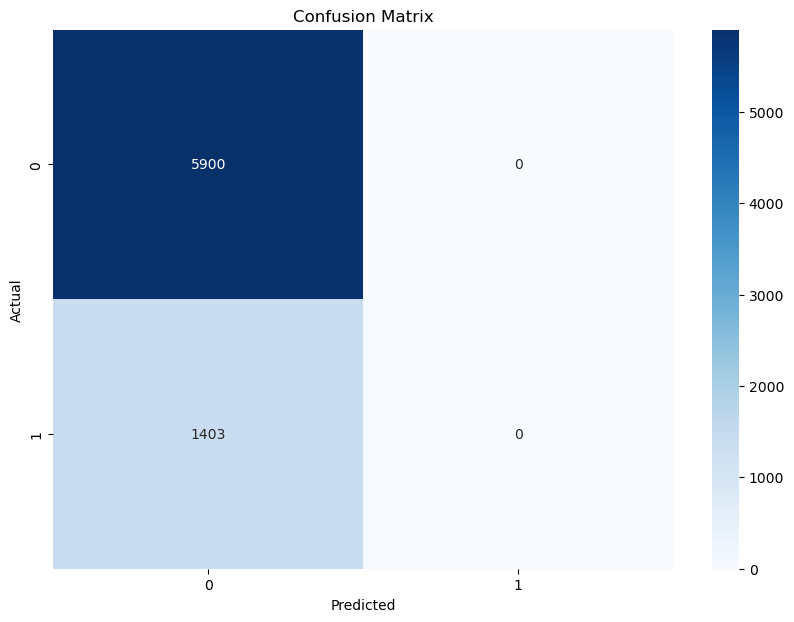

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      5900
           1       1.00      0.00      0.00      1403

    accuracy                           0.81      7303
   macro avg       0.90      0.50      0.45      7303
weighted avg       0.84      0.81      0.72      7303



In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred, zero_division=1)
print("Relatório de Classificação:")
print(class_report)

# Etapa 04) Modelagem dos Dados - Tunning


Critérios de Avaliação:

Para essa etapa os alunos precisam tunar os modelos e utilizar minimamente as seguintes funçoes para atingir uma acurácia maior: grid_search.best_estimator_.get_params(), fit, assign, ConfusionMatrixDisplay


Melhores parâmetros: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Acurácia: 0.8078871696563056
Precisão: 1.0
Recall: 0.0
F1-score: 0.0
Matriz de Confusão:


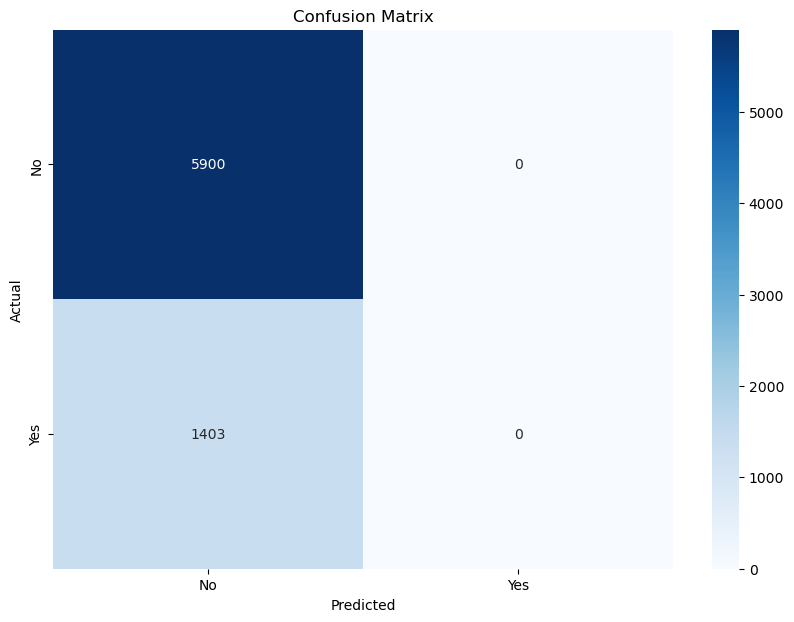

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      5900
           1       1.00      0.00      0.00      1403

    accuracy                           0.81      7303
   macro avg       0.90      0.50      0.45      7303
weighted avg       0.84      0.81      0.72      7303



In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'penalty': ['l2', None], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'max_iter': [100, 200, 300], 'l1_ratio': [0.5]}
]

log_reg = LogisticRegression()

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train, y_train)

y_pred_best = best_log_reg.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, zero_division=1)
recall_best = recall_score(y_test, y_pred_best, zero_division=1)
f1_best = f1_score(y_test, y_pred_best, zero_division=1)

print(f"Acurácia: {accuracy_best}")
print(f"Precisão: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1-score: {f1_best}")

conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print("Matriz de Confusão:")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report_best = classification_report(y_test, y_pred_best, zero_division=1)
print("Relatório de Classificação:")
print(class_report_best)

O modelo de regressão logística obteve um resultado muito insatisfatório. Ele não classificou nenhum registro como Churn. Vamos passar para a abordagem com o Random Forrest:

# Etapa 05) Modelagem dos Dados - Random Forest


Critérios de Avaliação:

Para esta etapa os alunos precisam modelar a base de dados para.  Eles precisam utilizar minimamente as seguintes funções: LabelEncoder, .fit, .transform, get_dummies, MinMaxScaler, train_test_split, predict, assign, ConfusionMatrixDisplay


Realizar a montagem do grid search


c:\Users\lucas\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



Melhores parâmetros: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Acurácia: 0.8366424756949199
Precisão: 0.6797945205479452
Recall: 0.28296507483962935
F1-score: 0.3995973829894313
Matriz de Confusão:


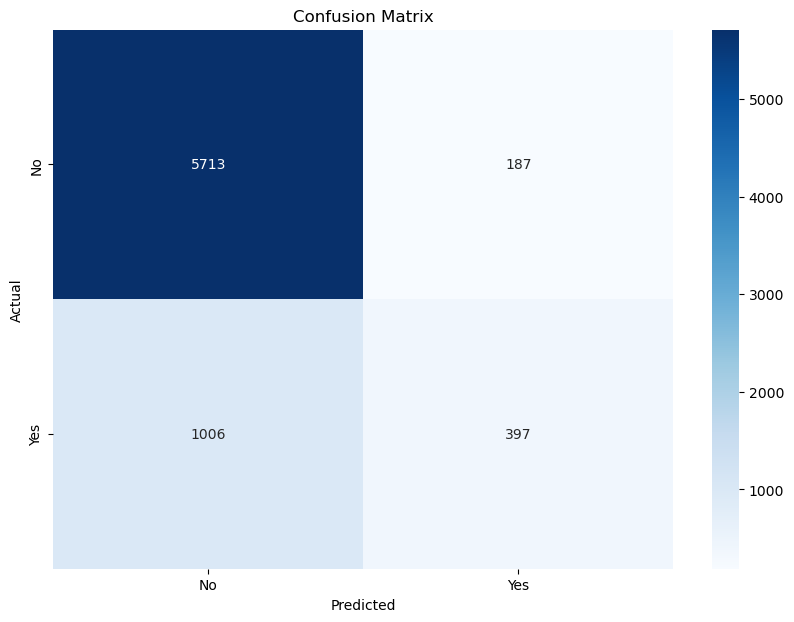

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      5900
           1       0.68      0.28      0.40      1403

    accuracy                           0.84      7303
   macro avg       0.77      0.63      0.65      7303
weighted avg       0.82      0.84      0.81      7303

{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}


In [22]:
def train_random_forest(scoring='f1'):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt

    param_grid_rf = {
        'n_estimators': [25, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)

    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring=scoring, n_jobs=-1, error_score='raise')
    grid_search_rf.fit(X_train, y_train)

    best_params_rf = grid_search_rf.best_params_
    print(f"Melhores parâmetros: {best_params_rf}")

    best_rf = grid_search_rf.best_estimator_
    best_rf.fit(X_train, y_train)

    y_pred_rf = best_rf.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, zero_division=1)
    recall_rf = recall_score(y_test, y_pred_rf, zero_division=1)
    f1_rf = f1_score(y_test, y_pred_rf, zero_division=1)

    print(f"Acurácia: {accuracy_rf}")
    print(f"Precisão: {precision_rf}")
    print(f"Recall: {recall_rf}")
    print(f"F1-score: {f1_rf}")

    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    print("Matriz de Confusão:")
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    class_report_rf = classification_report(y_test, y_pred_rf, zero_division=1)
    print("Relatório de Classificação:")
    print(class_report_rf)

    return best_params_rf

# Exemplo de uso da função
melhores_parametros = train_random_forest(scoring='f1')
print(melhores_parametros)

O Random Forrest obteve resultados melhores que a Regressão Logísitica após a otimização de parâmetros com foco no F1 Score. Mas o modelo perdeu 1042 Churns. Como na previsão de Churn o falso negativo é mais prejudicial que o falso positivo, vamos refazer essa etapa, mudando o foco da otimização para "Recall"


Melhores parâmetros: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Acurácia: 0.8388333561550048
Precisão: 0.7124060150375939
Recall: 0.2701354240912331
F1-score: 0.3917312661498708
Matriz de Confusão:


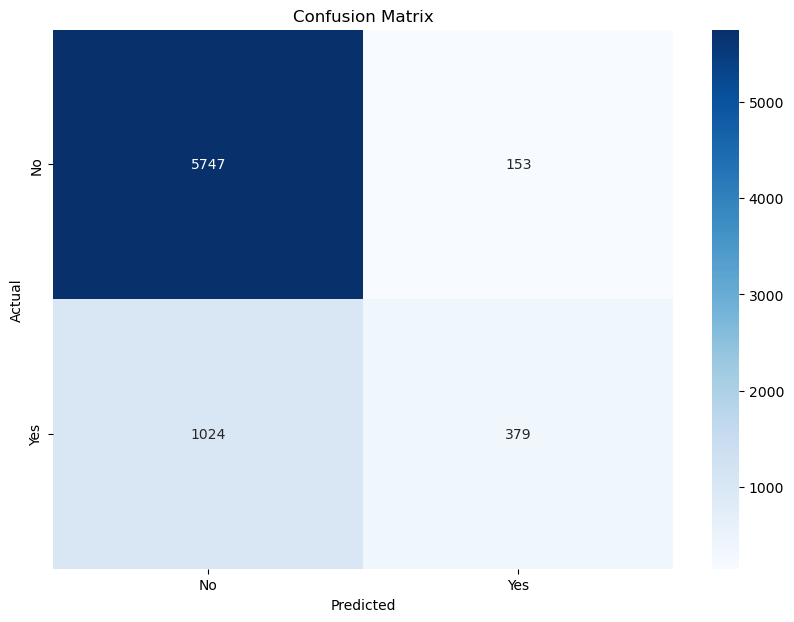

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      5900
           1       0.71      0.27      0.39      1403

    accuracy                           0.84      7303
   macro avg       0.78      0.62      0.65      7303
weighted avg       0.82      0.84      0.81      7303



In [22]:
train_random_forest(scoring='recall')

Conseguimos reduzir a quantidade de falsos negativos enquanto mantivemos um f1 Score. Ainda sim, entendo que o modelo precisa de mais estudos antes de entrar em produção.

# Conclusão

O melhor modelo foi o Random Forrest, com os parâmetros: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


# ATENÇÃO


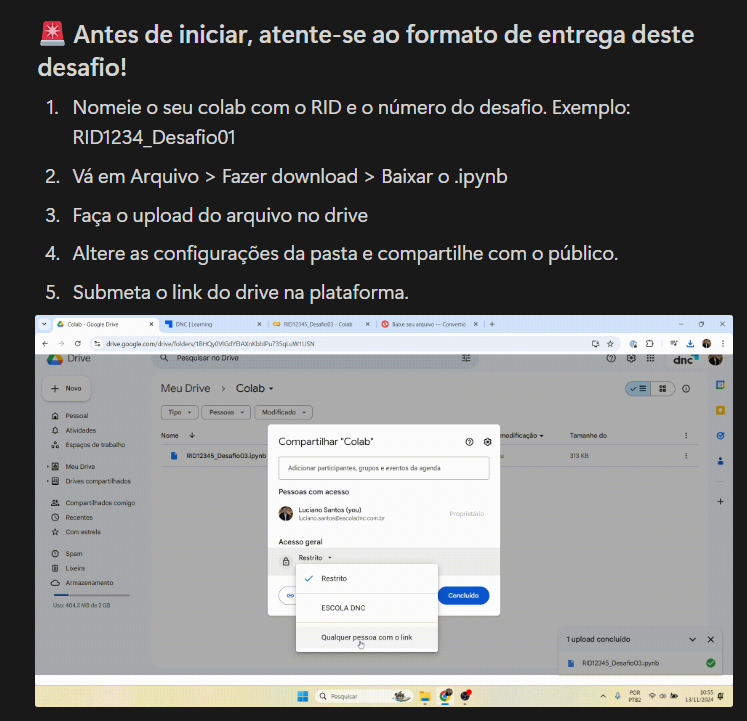